In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import datetime as dt
from datetime import date
from datetime import datetime

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
import joblib

import numpy as np
np.random.seed(0)
import scipy

import datetime as dt
from datetime import date

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## <font size="7">Zwischenfazit: LSTM</font><a class="anchor" id="4-03f-zwischenfazit"></a>

<font size="5">
Das Netz lässt sich theoretisch endlos erweitern oder optimieren. Es könnten weitere Schichten, mehr Neuronen, andere Arten von Schichten und Aktivierungsfunktionen etc. eingesetzt werden. Auch die Hyperparameter des Trainings könnten noch verändert werden. Da aber unmöglich alle denkbaren Kombinationen von Architekturen und Parametern ausprobiert werden können, wird das Netz nur näherungsweise optimiert. Folgende Erkenntnisse wurden während des Modeling gewonnen:
<br>1. Das Netz erzielt mit einer Dense-Schicht á 64 und einer LSTM-Schicht á 128 Neuronen sehr gute Ergebnisse
<br>2. Als Aktivierungsfunktion für die Dense-Schicht bietet sich die ReLu-Funktion an, in der LSTM-Schicht wird tanh verwendet.
<br>3. Die Fensterlänge ist mit 14 Zeitschritten angemessen. Kleinere Fenster führen zu Unteranpassungen, größere Fenster führen zu Überanpassungen und sehr viel komplexeren Modellen.
<br>4. Als Lernrate bietet sich 0,0005 in Verbindung mit einer Batchgröße von 8 an. Größere Batches führen nicht dazu, dass das Minimum der Verlustfunktion besser erreicht werden kann. Die Netze lernen zwar in frühen Epochen schnell an, allerdings haben weitere Epochen bei einer derart niedrigen Lernrate immer noch positive Effekte.
<br>5. Das Training erfolgt über 100 Epochen, da hier die Konvergenz des Modells auf den Test- beziehungsweise Validierungsdaten einsetzt.
<br>6. Ab etwa der 60. Epoche kommt es zu leichten Überanpassungen an die Trainingsdaten. Diese lassen sich durch eine L2-Regularisierung mit einer Stärke von 0,0001 teilweise beheben. Höhere Regularisierungsstärken frühen zu Unteranpassungen, da der Lernprozess zu stark gestört wird. Selbst kleine Dropouts führen zu starken Unteranpassungen und lassen sich daher nicht für das Modell verwenden.
<br><br>Es wird als ein zweischichtiges Netz aus einer Dense-Schicht á 64 und einer LSTM-Schicht á 128 Neuronen trainiert. Die Dense-Schicht wird mit der ReLu-Funktion, die LSTM-Schicht mit tanh aktiviert. Für die LSTM-Schicht wird eine Fenster über 14 Zeitschritte verwendet. Das Training erfolgt über 100 Epochen mit Batches der Größe 8 und einer Regularisierung von 0,0001.
</font>


### <font size="5">Modell und Parameter</font>

In [3]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    regularizer = l2(0.0001)
    
    model.add(Dense(units=64, kernel_regularizer=regularizer, activation="relu"))
    model.add(LSTM(units=128, kernel_regularizer=regularizer, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [4]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.05            1.63               1.90
2             2.06            1.35               1.84
3             2.12            1.47               1.81
4             2.01            1.50               1.93
5             1.98            1.49               1.81
Average       2.04            1.49               1.86





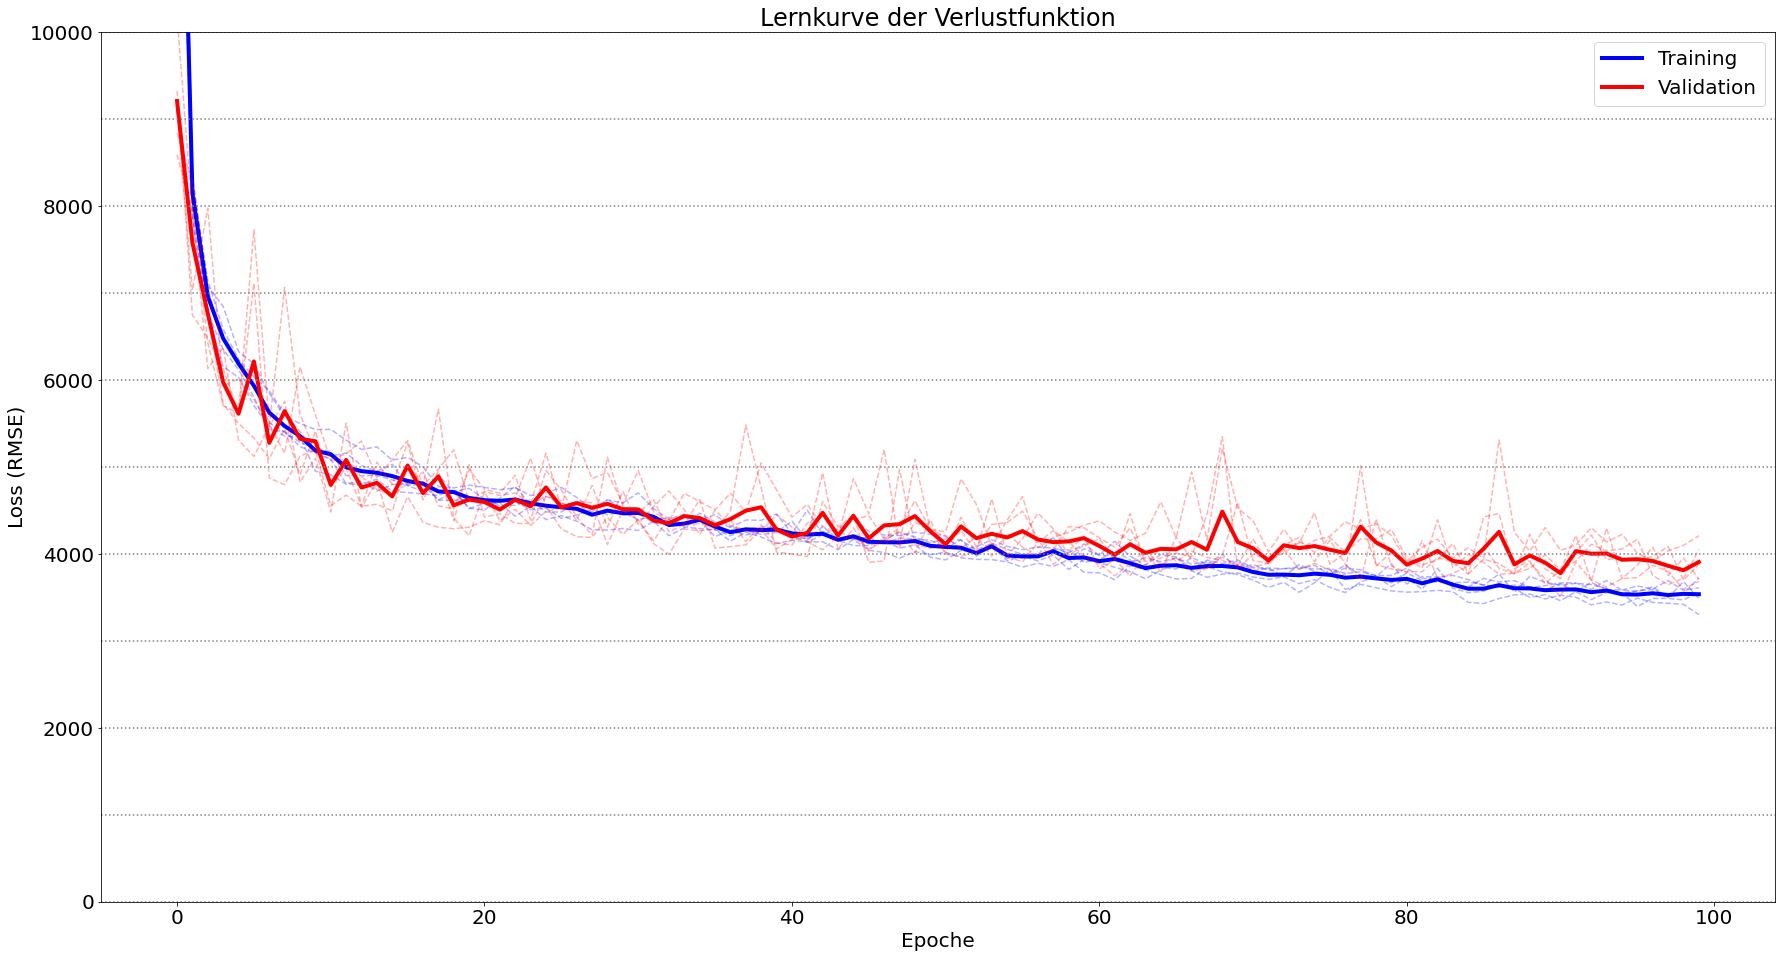

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 10000)

<font size="5">
Das Modell erreicht einen MAPE von 1,94% auf den Testdaten und ist damit etwas besser als die während der Kreuzvalidierung erstellten Modelle. Der Unterschied ist allerdings sehr gering und kann vermutlich auf die größere Datenbasis beim finalen Test zurückgeführt werden. Auf den Trainingsdaten wird ein MAPE von 1,37% erreicht, hier zeigt sich also immer noch die leichte Überanpassung, die in der Lernkurve ab etwa der 60. Epoche einsetzt. Die Überanpassung ist allerdings gering ausgeprägt und lässt sich nicht weiter kompensieren. Sie wird daher akzeptiert. Restriktionen und Vorbehalte bezüglich des Trainings und der hier erzielten Ergebnisse sind in der Ausarbeitung zu finden.
</font>


### <font size="5">Test</font>

In [10]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 3s 7ms/step - loss: 0.1061
Epoch 2/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0577
Epoch 3/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0514
Epoch 4/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0471
Epoch 5/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0455
Epoch 6/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0443
Epoch 7/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0416
Epoch 8/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0403
Epoch 9/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0396
Epoch 10/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0383
Epoch 11/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0382
Epoch 12/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0371
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.97           0.99
MAE       3226.0         2213.0
MSE   19654252.0     10226540.0
RMSE      4433.0         3198.0
                               
MAPE      1.94 %         1.37 %


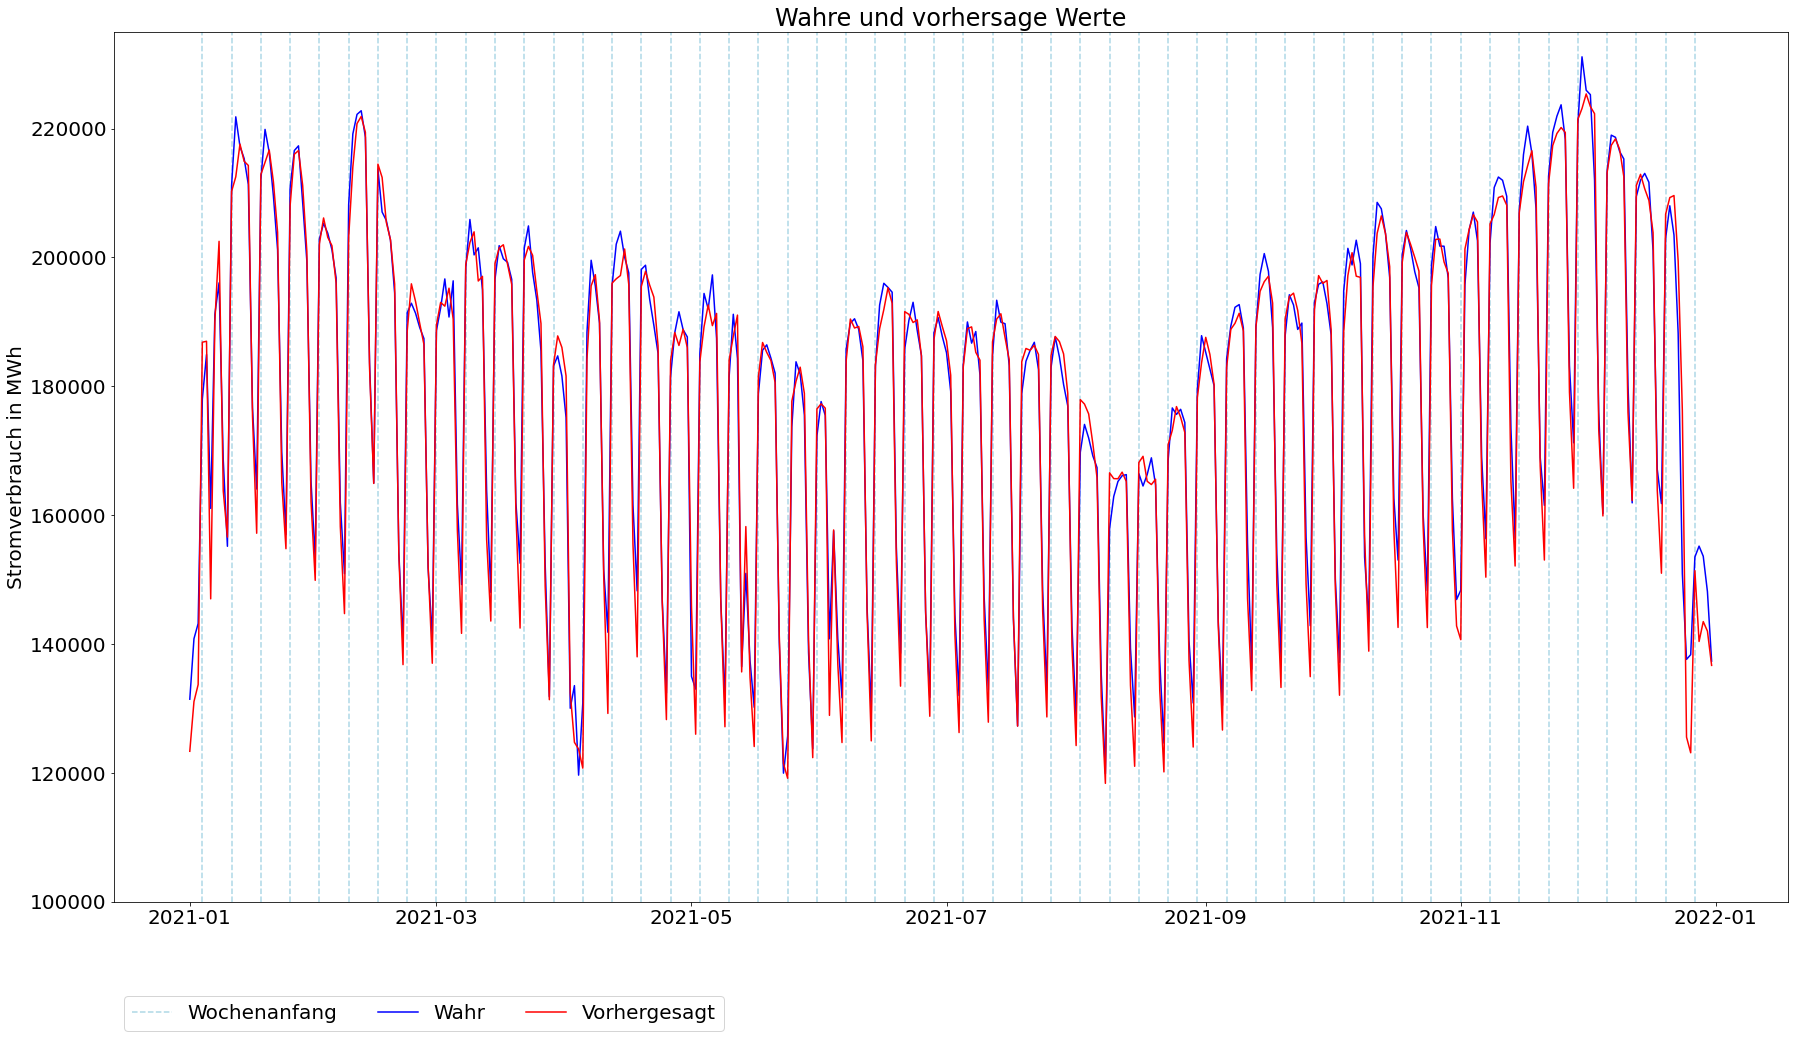

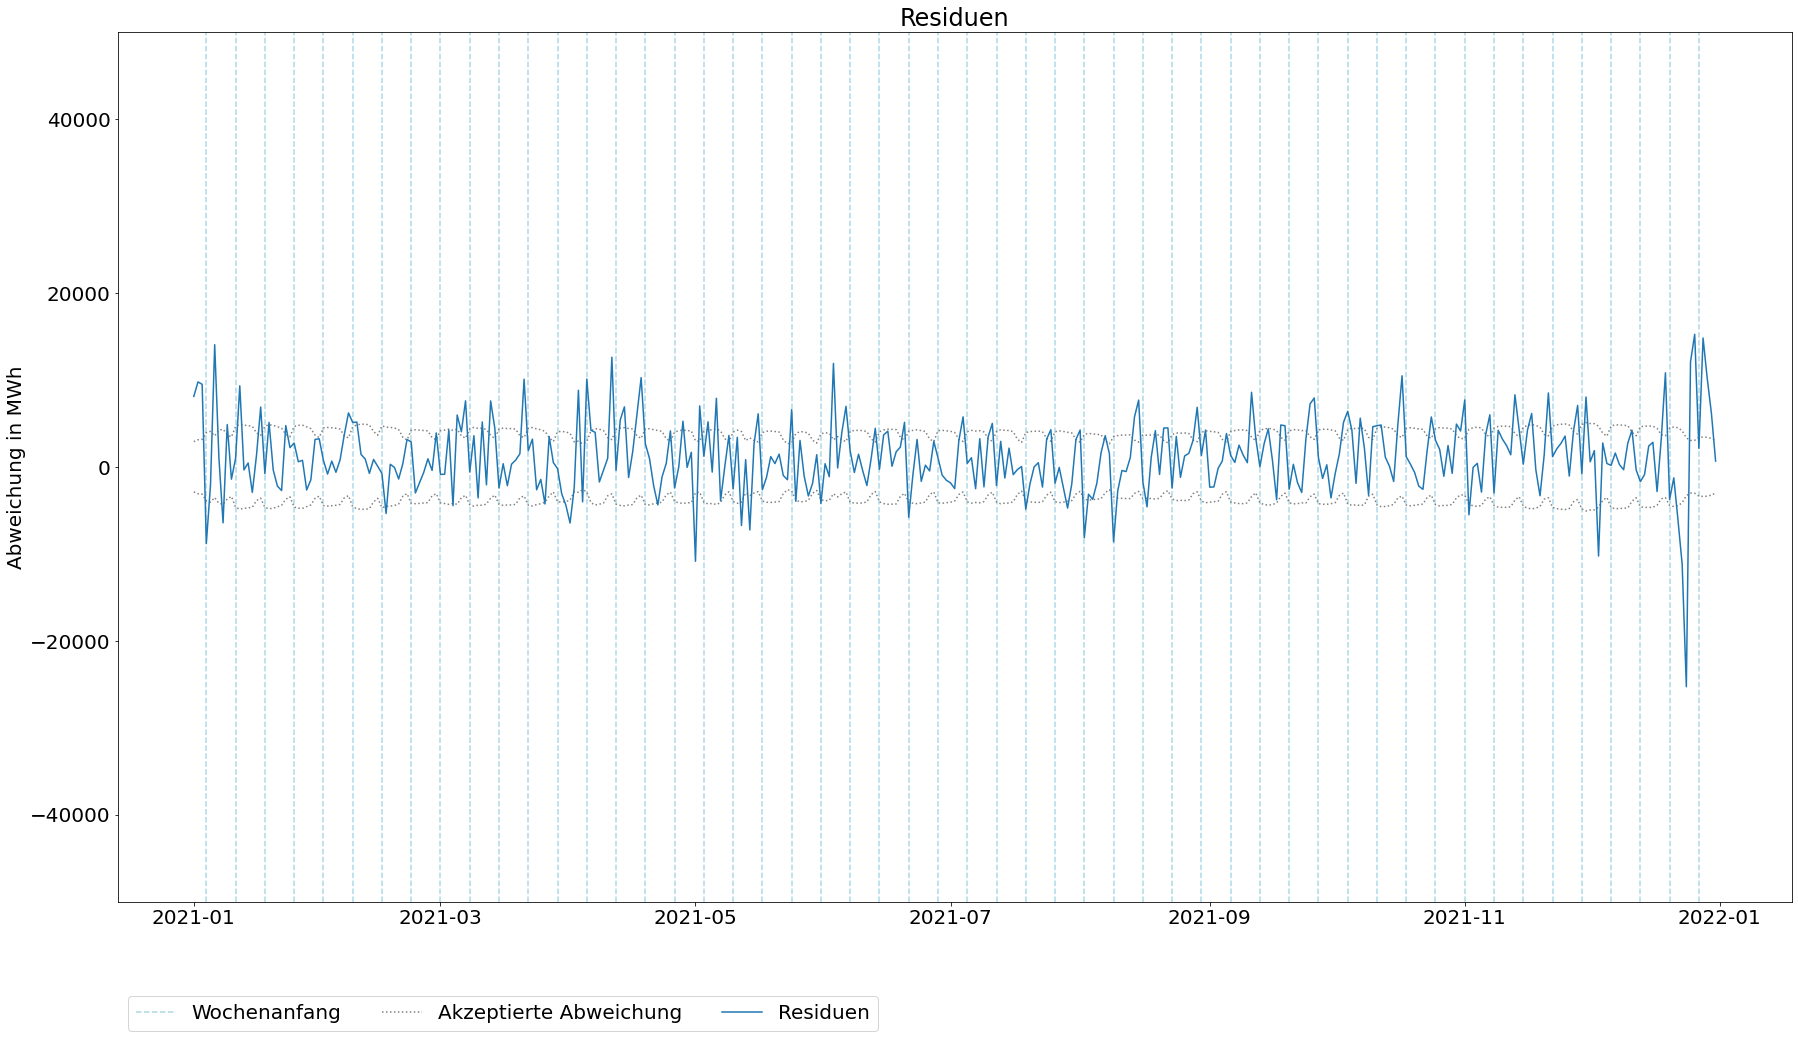

In [10]:
## Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

### <font size="5">Modell speichern</font>

In [6]:
#model.save("Modelle/LSTM.h5"),

#from tensorflow.keras.models import load_model
#newmodel = load_model("Modelle/LSTM.h5", custom_objects={"root_mean_squared_error":root_mean_squared_error})
#newmodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 14, 64)            320       
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 99,265
Trainable params: 99,265
Non-trainable params: 0
_________________________________________________________________


# <font size="7">Vergleich mit Baseline</font><a class="anchor" id="4-02e-baseline"></a>

<font size="5">
Im Vergleich zur Baseline sind die Vorhersagen des Modells besser als die Baseline. Vor Allem die wöchentliche Saisonalität kann besser abgebildet werden. In der Urlaubssaison Ende des Jahres kommt es zwar bei beiden Modellen zu Abweichungen, allerdings schneidet die Baseline hier etwas besser ab. Das Erfolgskriterium eines MAPE von höchstens 2,2% ist erfüllt.
</font>


In [5]:
#model.save("Modelle/LSTM.h5"),

from tensorflow.keras.models import load_model
model = load_model("Modelle/LSTM.h5", custom_objects={"root_mean_squared_error":root_mean_squared_error})
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 14, 64)            320       
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 99,265
Trainable params: 99,265
Non-trainable params: 0
_________________________________________________________________


In [6]:
window_size = 14

#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

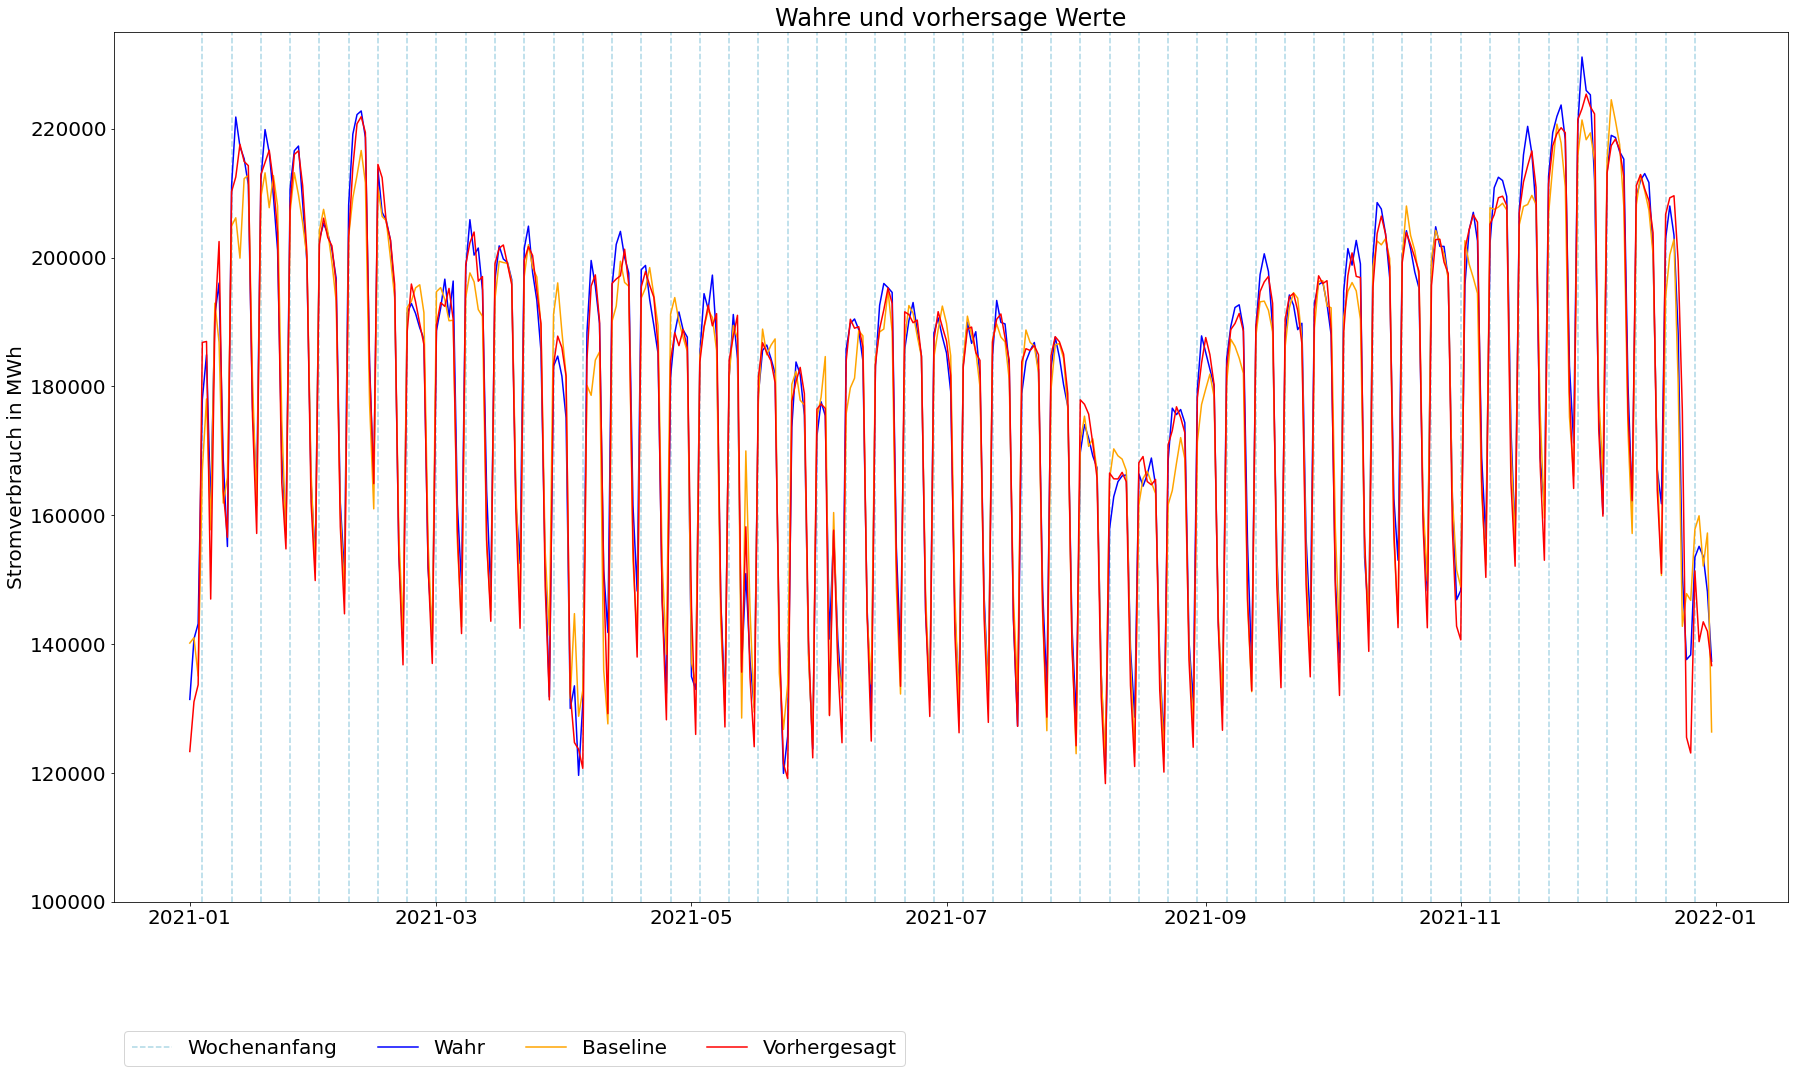

In [11]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

#Wahre Werte der Testdaten
y_true = df_unscaled["verbrauch"]["2021-01-01":]

#Baseline-Vorhersage laden
df_baseline = pd.read_csv("../1-Business Understanding/data_baseline.csv", index_col=0, parse_dates=True)["2021-01-01":]

#Vorhersagen für Testdaten erstellen
scaled_preds = model.predict(X_test)

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")
lstm_preds = pd.DataFrame(data=scaler_target.inverse_transform(scaled_preds.reshape(-1, 1)), columns=["vorhergesagt"], index=pd.date_range('01/01/2021', periods=365, freq='D')).squeeze()

for date in y_true[y_true.index.weekday == 0].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="lightblue", linestyle="--", label="Wochenanfang")

plt.plot(y_true, color="blue", label="Wahr");
plt.plot(df_baseline, color="orange", label="Baseline");
plt.plot(lstm_preds, color="red", label="Vorhergesagt");
plt.title("Wahre und vorhersage Werte")
plt.ylabel("Stromverbrauch in MWh")
plt.ylim(100000,235000)
plt.legend(loc="upper right")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()

In [12]:
print("Vorhersage:")
functions.custom_metrics(y_true, lstm_preds, statistics=True, plot=False)

print("-------------------------------------------------------------------------------------------------")
print("Baseline:")
functions.custom_metrics(y_true, df_baseline, statistics=True, plot=False)

Vorhersage:
      Vorhersage
R2           1.0
MAE       3226.1
MSE   19654252.3
RMSE      4433.3
                
MAPE       1.9 %
-------------------------------------------------------------------------------------------------
Baseline:
      Vorhersage
R2           1.0
MAE       4271.2
MSE   29925346.3
RMSE      5470.4
                
MAPE       2.4 %


<font size="5">
Die Residuen des LSTM-Modells befinden sich die meiste Zeit unter oder minimal über der akzeptierten Abweichung von 2,2%. Auffällig ist außerdem, dass Feiertage das ganze Jahr über etwas besser erkannt werden als bei der Baseline. Lediglich an den Weihnachtsfeiertagen und unmittelbar danach kommt es zu größeren Abweichungen als bei der Baseline. 
</font>


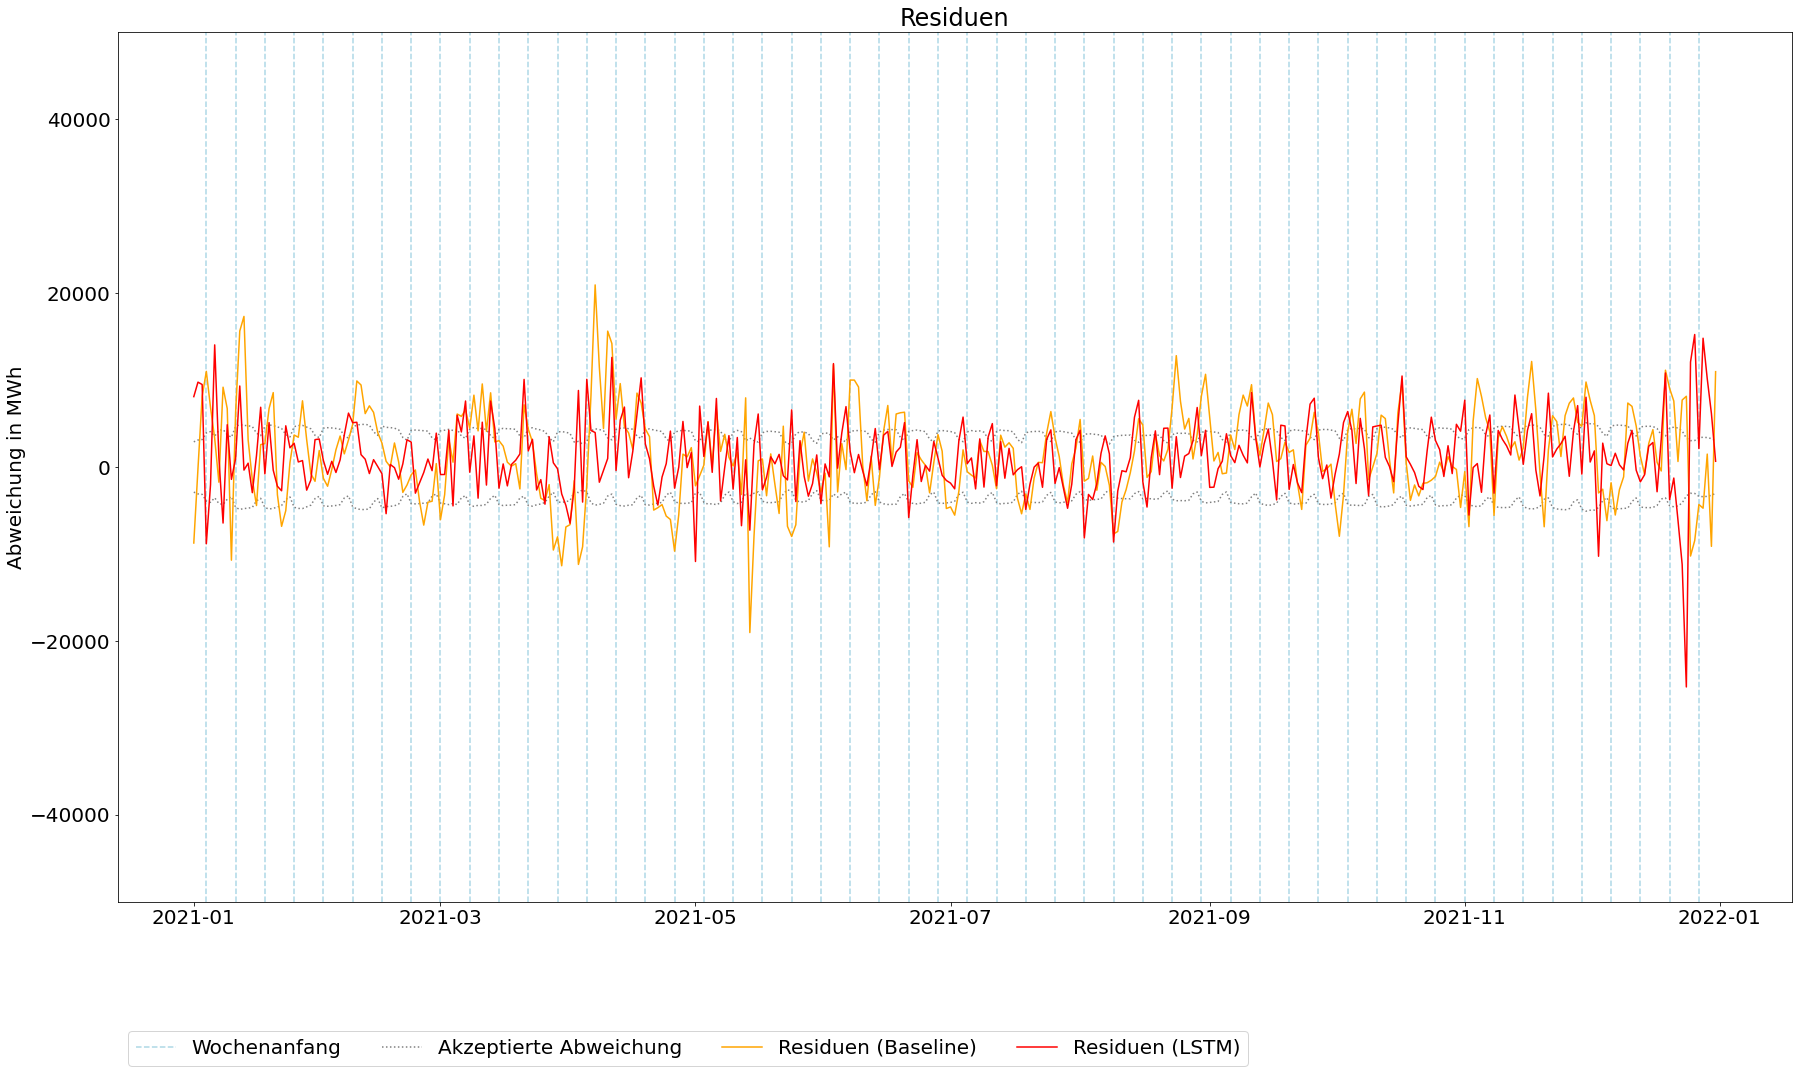

In [15]:
for date in y_true[y_true.index.weekday == 0].index:

    plt.axvline(x=date, ymin=0, ymax=1, color="lightblue", linestyle="--", label="Wochenanfang")

resids_preds = y_true - lstm_preds
resids_baseline = y_true - df_baseline["vorhergesagter verbrauch"]["2021-01-01":]

y_upper_deviation = y_true * 0.022
y_lower_deviation = y_upper_deviation * -1

plt.plot(y_upper_deviation, color="grey", linestyle=":", linewidth=1.5, label="Akzeptierte Abweichung")
plt.plot(y_lower_deviation, color="grey", linestyle=":", linewidth=1.5)

plt.plot(resids_baseline, color="orange", label="Residuen (Baseline)")
plt.plot(resids_preds, color="red", label="Residuen (LSTM)")
plt.ylabel("Abweichung in MWh")
plt.ylim(-50000, 50000)
plt.title("Residuen")

#Legende einfügen
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0,-0.2), ncol=5)

plt.show()